In [51]:
# Obtiene los datos de precipitación par la Cuenca del Valle
# de Méxco a partir de CHIRPS y los promedia espacialmente.

import os

import rioxarray

import pandas as pd
import numpy as np
import matplotlib

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Permite ajustar los valores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

In [52]:
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]

path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

# Se abre el archivo histórico y el del año en curso.
ds = xr.open_mfdataset( [ path_nc + x for x in names[0:2] ],
    combine = "nested", concat_dim = "time", parallel = True )

# Quitamos los 29 de febrero.
ds = ( ds.sel( time = ~( (ds.time.dt.month == 2) & (ds.time.dt.day == 29) ) ) )

ds

<xarray.Dataset>
Dimensions:    (time: 14812, longitude: 31, latitude: 35)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-07-31
  * longitude  (longitude) float32 -99.73 -99.68 -99.63 ... -98.33 -98.28 -98.23
  * latitude   (latitude) float32 19.07 19.12 19.17 19.22 ... 20.67 20.72 20.77
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(14600, 35, 31), meta=np.ndarray>
Attributes: (12/17)
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Mon Sep 13 20:14:46 2021: cdo mergetime cuenca_valle_m...
    institution:       Climate Hazards Group.  University of California at Sa...
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    version:           Version 2.0
    ...                ...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

In [53]:
# Se carga el contorno de México.
gdf = gpd.read_file(path_shp + names[2])

# Se obtiene el contorno de los países.
gdf["boundary"] = gdf.boundary

# Se establece el datum de los datos.
ds = ds.rio.write_crs(gdf.crs)

# Se hace la máscara de México.
clip = ds.rio.clip(
    gdf[gdf["ORG_CUENCA"] == "Aguas del Valle de México"].geometry,
    gdf.crs, drop=False, invert=False).drop("spatial_ref")

In [54]:
# Cantidad de días a promediar.
d = 15

# Precipitación diaria promedio en toda la cuenca.
df = ( clip.mean(dim = ["latitude", "longitude"]).to_dataframe() )

#df["percentage"] = None

# Cantidad de puntos en la cuenca.
n = ( clip.isel(time = 0)
    .where(clip.isel(time = 0)["precip"] < 0, 1)
    .where(clip.isel(time = 0)["precip"] >= 0, 0)
    .sum(dim = ["latitude"])
    ).to_dataframe()["precip"].sum()

# Porcentaje de puntos con precipitación.
i = clip.where(clip["precip"] > 0, 0)
df.loc[i["time"].values, "percentage"] = ( i
    .where(i["precip"] <= 0, 1)
    .sum(dim = ["latitude", "longitude"])
    )["precip"].values / n
# Media móvil centrada a 15 días.
df["percentage"] = ( df["percentage"].rolling(
    window = d, center = True).mean() )

# Media móvil de precipitación centrada a 15 días.
#df[["precip_15", "percentage_15"]] = (
#    df[["precip", "percentage"]]
#    .rolling(window = 15, center = True).mean() )
df["precip"] = ( df["precip"].rolling(
    window = d, center = True).mean() )
df.columns = ["Cuenca", "percentage"]

# Pentada.
#df[["precip_5", "percentage_5"]] = (
#    df[["precip", "percentage"]]
#    .rolling(window = 5, center = True).mean() )

# Se guardan los datos.
df.to_csv(path_d + "pre_daily_CHIRPS.csv")

print(n)

#df

570.0


2 mm/día, 6 días consecutivos, 150 días de duración
2.3 mm/día, 6 días consecutivos, 143 días de duración
3 mm/día, 6 días consecutivos, 118 días de duración
2 mm/día, 10 días consecutivos, 141 días de duración
2.3 mm/día, 10 días consecutivos, 131 días de duración
3 mm/día, 10 días consecutivos, 106 días de duración
2 mm/día, 14 días consecutivos, 127 días de duración
2.3 mm/día, 14 días consecutivos, 112 días de duración
3 mm/día, 14 días consecutivos, 91 días de duración


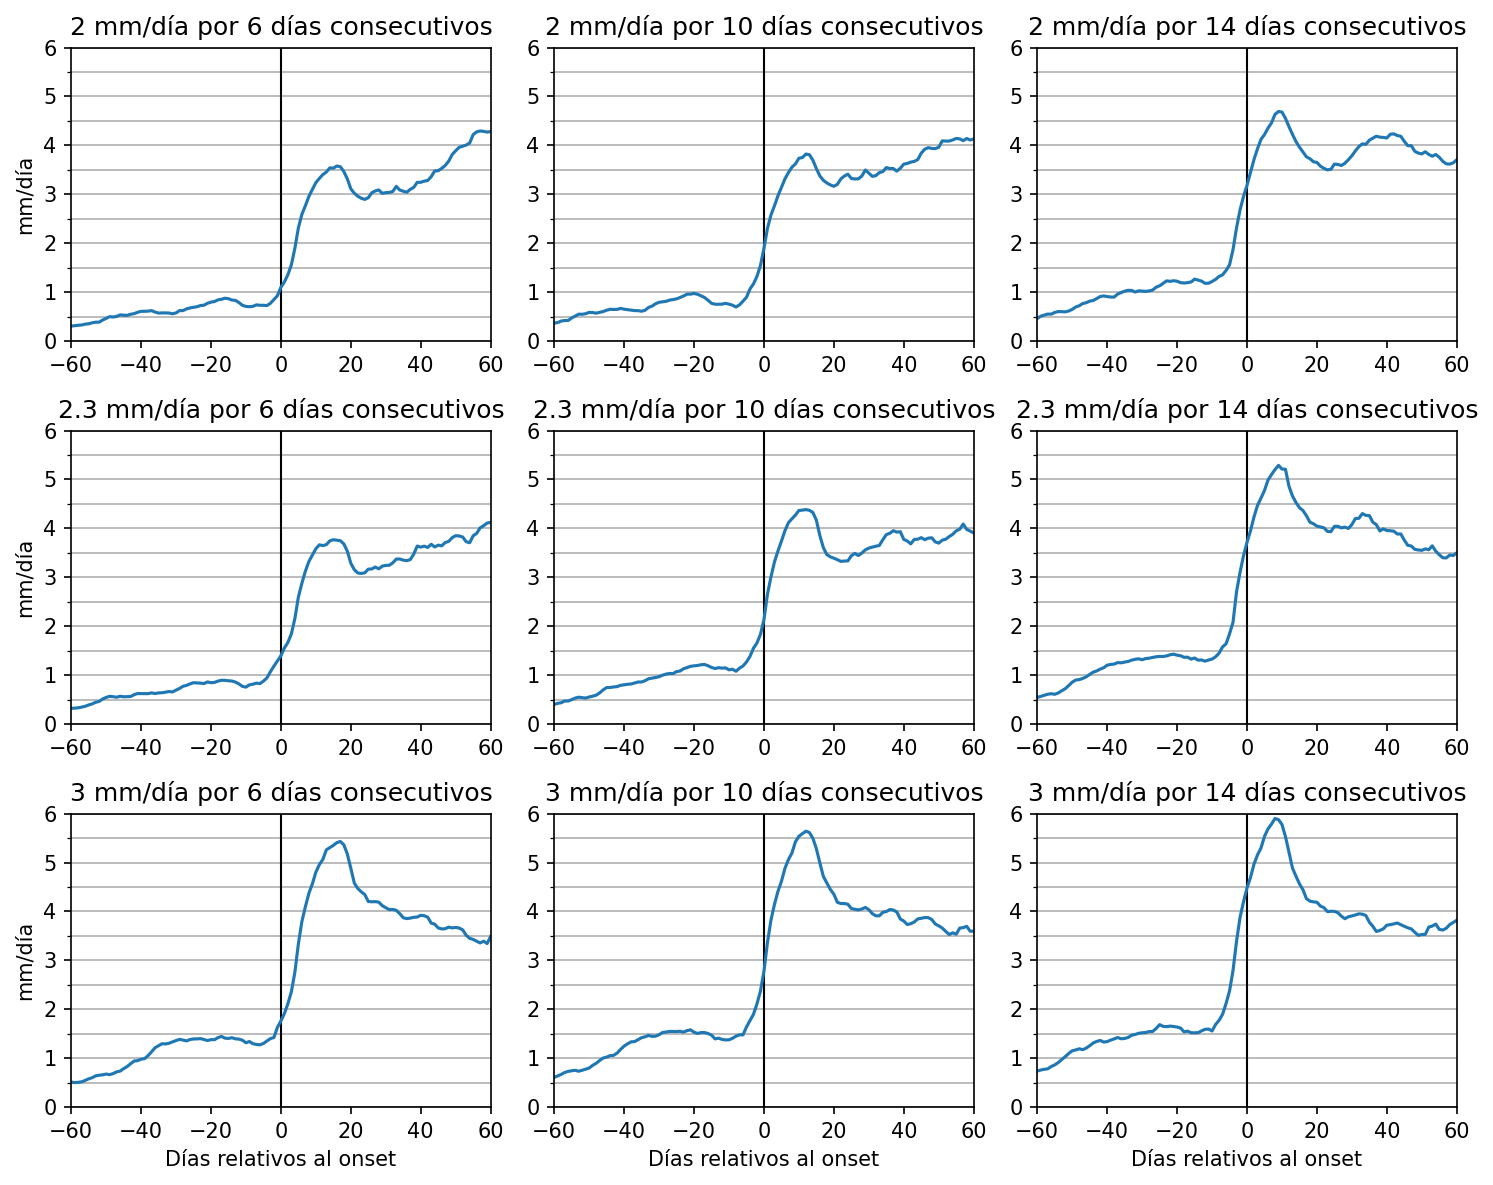

In [55]:
#path_r = "../results/onset/"
#fname_d = path_r  + "pre_daily_CHIRPS.csv"

#df_mean = pd.read_csv(fname_d, index_col = "time")
#df_mean.index = pd.to_datetime(df_mean. index)

df_mean = df.copy()

# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [2, 2.3, 3]
dias = [6, 10, 14]

m_i = 4

n = 3

lim = [6, 0.6]
step = [0.5, 0.05]
title = ["onset_criteria_CHIRPS.png", "distribucion_espacial_CHIRPS.png"]
fig_s = [None] #* 2
axes_s = [None] #* 2

for i in range( len(fig_s) ):
    # Ajustes de gráficas múltiples.
    fig_s[i], axes_s[i] = plt.subplots(len(umbral), len(dias))
    fig_s[i].set_facecolor("w")
    fig_s[i].set_size_inches(10, 8)
    fig_s[i].set_dpi(150)

for i_n, n in enumerate(dias):
    for i_u, u in enumerate(umbral):
        df_mean_ind = pd.DataFrame(
            df_mean.copy(), columns = ["Cuenca"] )

        c = "Cuenca"

        # Nombre de las columnas dummy.
        proc = [c]
        for i in range(0, n):
            proc.append(c +
                "_" + str(i)) 

        # Traslapa los últimos n días 
        # y da un valor de 1 a cada día 
        # que cumpla con el umbral.
        for i, p in enumerate(proc[1:]):
            df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
            df_mean_ind[p].clip( upper = u,
                inplace = True )
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] == u, 0)
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] < u, 1)

        # El índice es uno si los n
        # cumplen con el umbral.
        ind = "Index_" + c
        df_mean_ind[ind] = 0
        for i in range(n):
            df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] == n, 0)
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] < n, 1)
        df_mean_ind.drop(proc[1:],
            axis = 1, inplace = True)

        # Crea una tabla con los valores anuales.
        col = []
        name = "Cuenca"
        col.append(name + " - Onset")
        col.append(name + " - Withdrawal")
        col.append(name + " - Length")

        date = pd.DataFrame()
        years = range(1981, 2022)

        for j in years:
            # Solo utilizamos valores entre mayo y diciembre.
            df_year = df_mean_ind[ (df_mean_ind.index.year == j)
                & df_mean_ind.index.month.isin(range(m_i, 12)) ]

            row = []

            # Fechas.
            row.append( df_year.iloc[:, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax()
                - df_year.iloc[:, 1].idxmax() )

            # Agregamos la fila al DataFrame.
            date = date.append([row])

        # Damos formato a las columnas y al índice.
        date.columns = col
        date.index = years
        date.index.name = "Año"
        # Recorremos al inicio de la racha de días de precipitación.
        date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(10, 'D')

        # Longitud de la temporada de lluvias.
        print(f"{u} mm/día, {n} días consecutivos, " +
            f"{date.iloc[:, 2].mean().days} días de duración")

        # Calculamos el shift necesario para alinear las fechas.
        shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
        delta = shift.max()
        shift = shift.max() - shift

        for i in range( len(fig_s) ):

            # Creamos un DataFrame con año
            # como columnas y días como filas.
            pre_df = pd.DataFrame(
                df_mean.copy(), columns = [ df_mean.columns[i] ] )
            pre_df["Año"] = pre_df.index.year
            pre_df["Día"] = pre_df.index.dayofyear

            # Ajustamos el dayofyear de años bisiestos.
            qty = int( pre_df[pre_df.index.is_leap_year
                ].shape[0] / 365 )
            pre_df.loc[pre_df.index.is_leap_year, "Día"
                ] = list(range(1, 366)) * qty

            # Convertimos los años a columnas.
            pre_df = pre_df.pivot(index = "Día", columns = "Año")
            pre_df.columns = pre_df.columns.droplevel(0)

            # Alineamos las series de tiempo.
            for j in pre_df.columns:
                pre_df[j] = pre_df[j].shift(shift[j])

            # Promediamos y seleccionamos 120 días.
            pre_df = pre_df.mean(axis = 1)
            pre_df = pre_df.loc[delta - 60: delta + 60]
            pre_df.index = range(-60, 61)

            # Graficamos.
            axes_s[i][i_u, i_n].plot( (0, 0), (0, 7), color = "k",
                linewidth = 1 )
            pre_df.plot(ax = axes_s[i][i_u, i_n])

            axes_s[i][i_u, i_n].set_title(
                f"{u} mm/día por {n} días consecutivos")
            axes_s[i][i_u, i_n].set_xlim(-60, 60)
            axes_s[i][i_u, i_n].set_ylim(0, lim[i])

            if i_n == 0: 
                axes_s[i][i_u, i_n].set_ylabel("mm/día")
            if i_u == 2: 
                axes_s[i][i_u, i_n].set_xlabel("Días relativos al onset")

            for ax in axes_s[i].flatten():
                ax.set_yticks( np.arange(0, lim[i], step[i]), minor = True )
                ax.grid( visible = True, which = "both", axis ="y" )

            # Separación adecuada entre gráficas.
            fig_s[i].tight_layout()

            # Guardamos el archivo.
            #fig_s[i].savefig( path_r + title[i] )

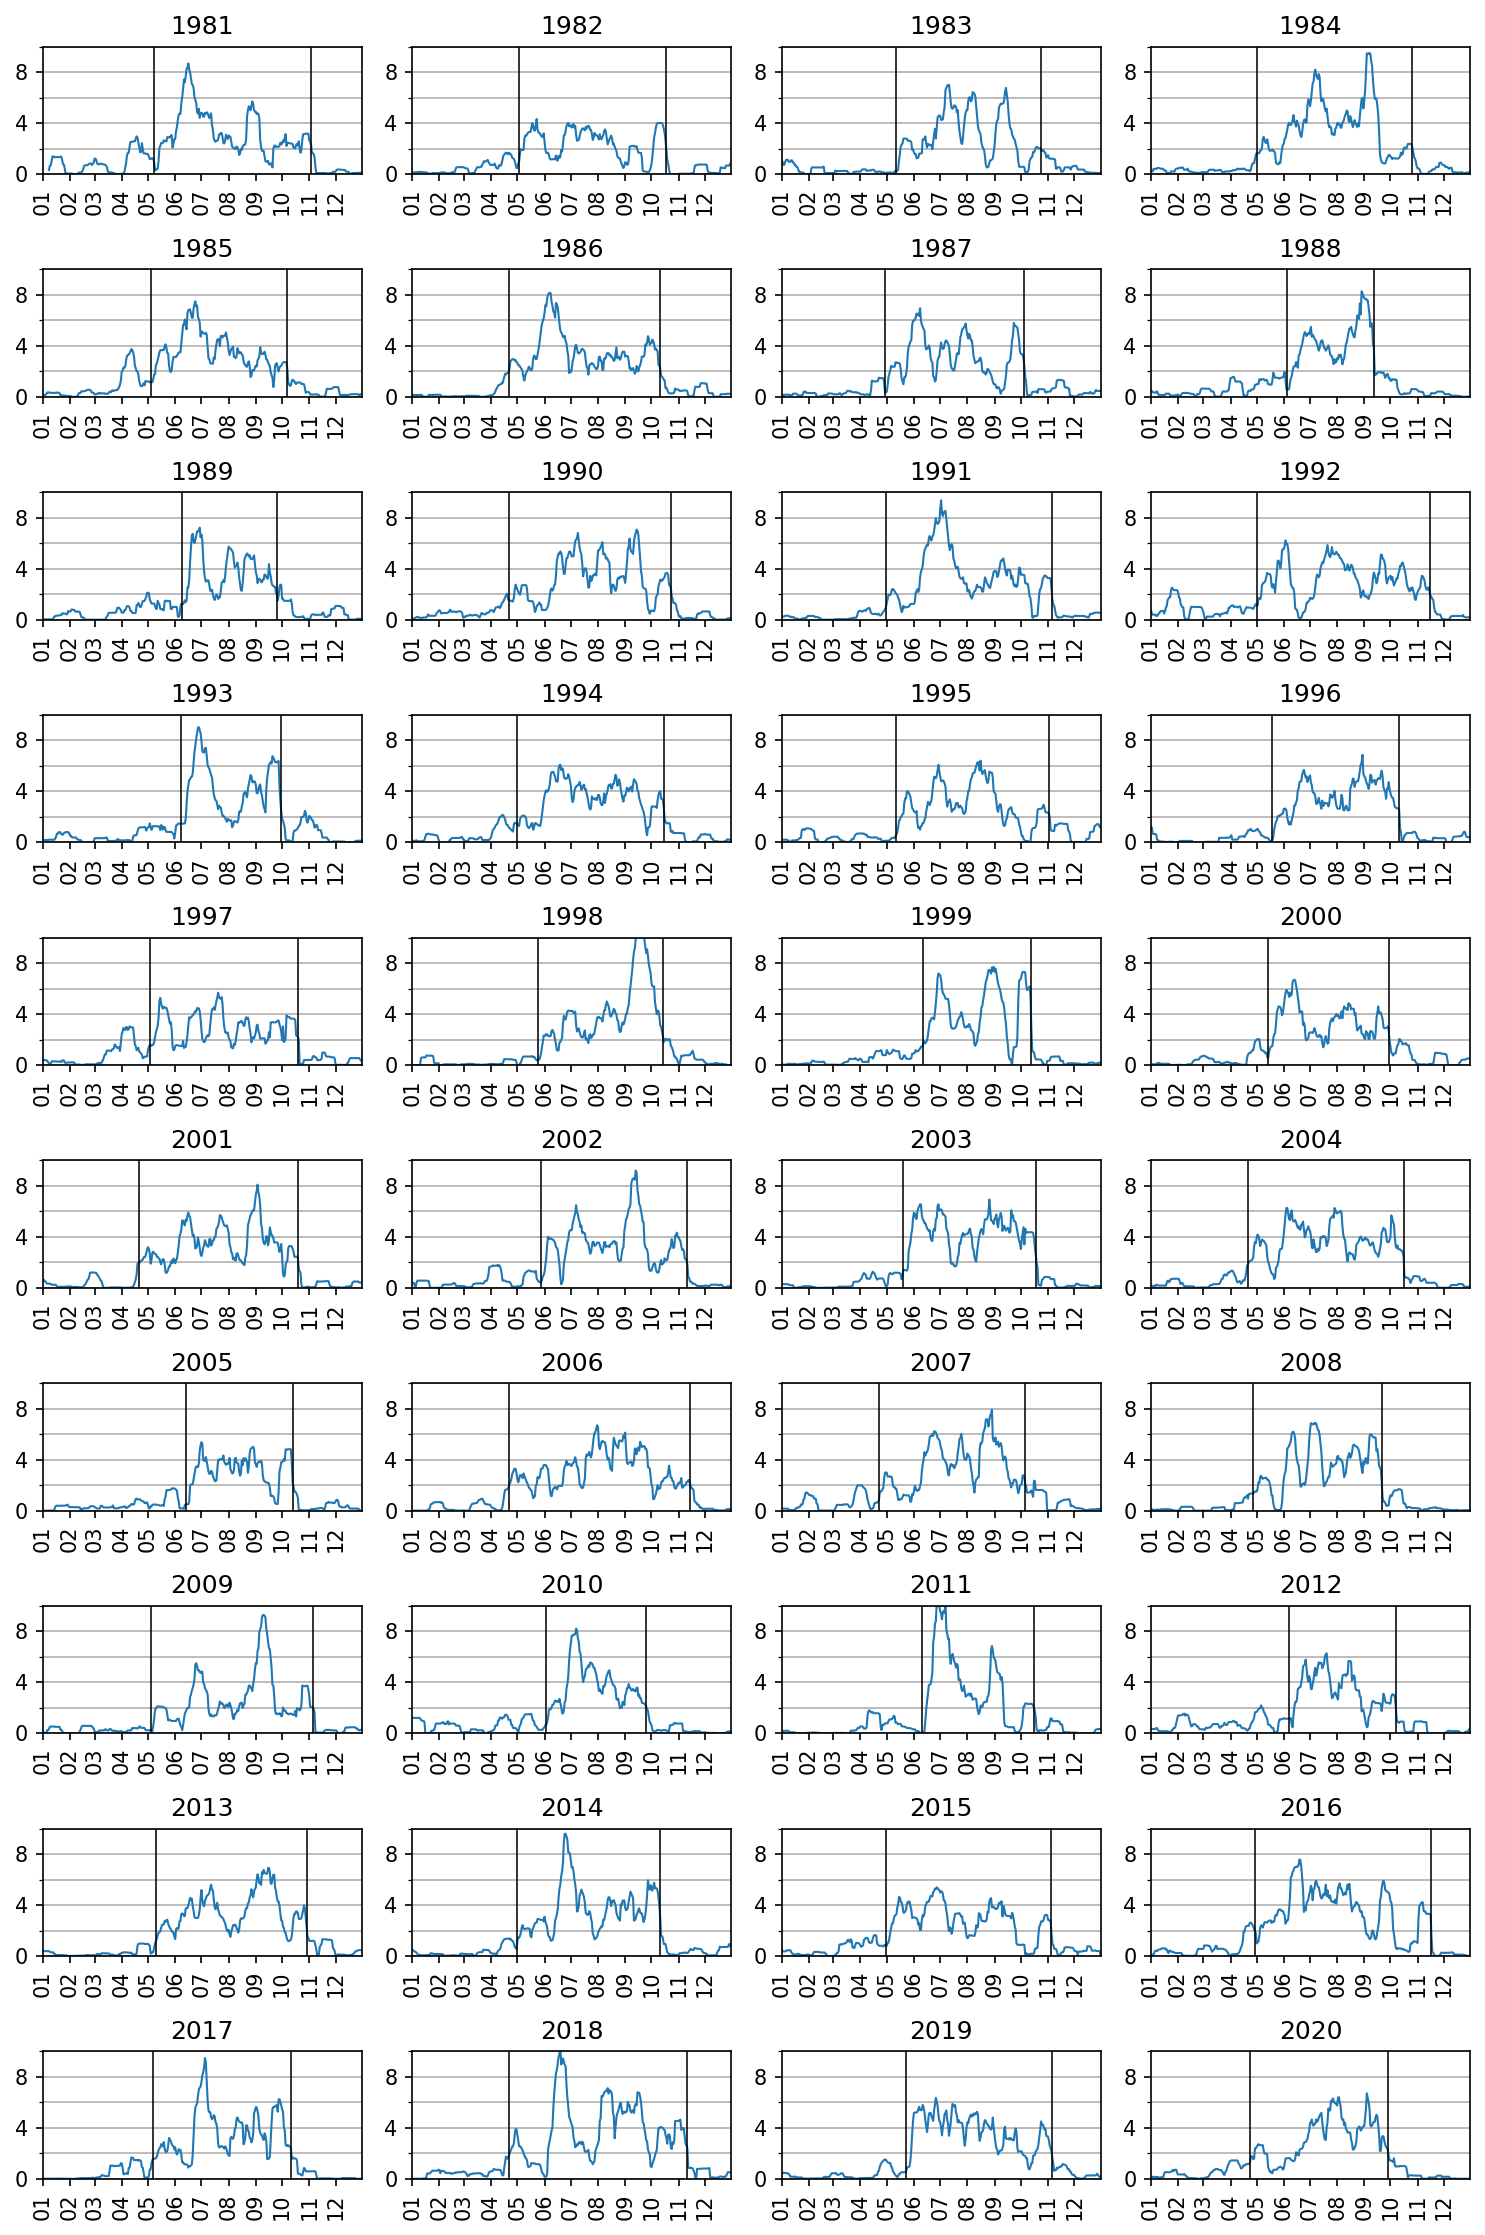

In [56]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = 2
n = 5

m_i = 4

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

c = "Cuenca"

# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n):
    proc.append(c + "_" + str(i)) 

# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral,
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral, 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral, 1)

# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] == n, 0)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] < n, 1)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where( df_mean_ind.index.month.isin(
    range(5, 12) ), 0 )
df_mean_ind.drop(proc[1:],
    axis = 1, inplace = True)

# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
col.append(name + " - Length")

date = pd.DataFrame()
years = range(1981, 2021)

for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & df_mean_ind.index.month.isin(range(m_i, 12)) ]

    row = []

    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax()
        - df_year.iloc[:, 1].idxmax() )

    # Agregamos la fila al DataFrame.
    date = date.append([row])

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"
# Recorremos al inicio de la racha de días de precipitación.
date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(10, 'D')

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)

# Guarda las series de tiempo.
date.to_csv(path_d + "onset_CHIRPS.csv")
shift.to_csv(path_d + "shift_CHIRPS.csv")

year = np.arange( 1981, 2021 )

#print(f"Onset     : {onset.day:02d}"
#    + f" {onset.month_name()}")
#print(f"Withdrawal: {withdrawal.day:02d}"
#    + f" {withdrawal.month_name()}")

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]


for i in range( len(year) ):
    df_year = df_mean_ind[ df_mean_ind.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (0, 12), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(0, 10)
    #axes[i].set_ylim(0, np.ceil(df_year.iloc[:, 0].max()) )
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

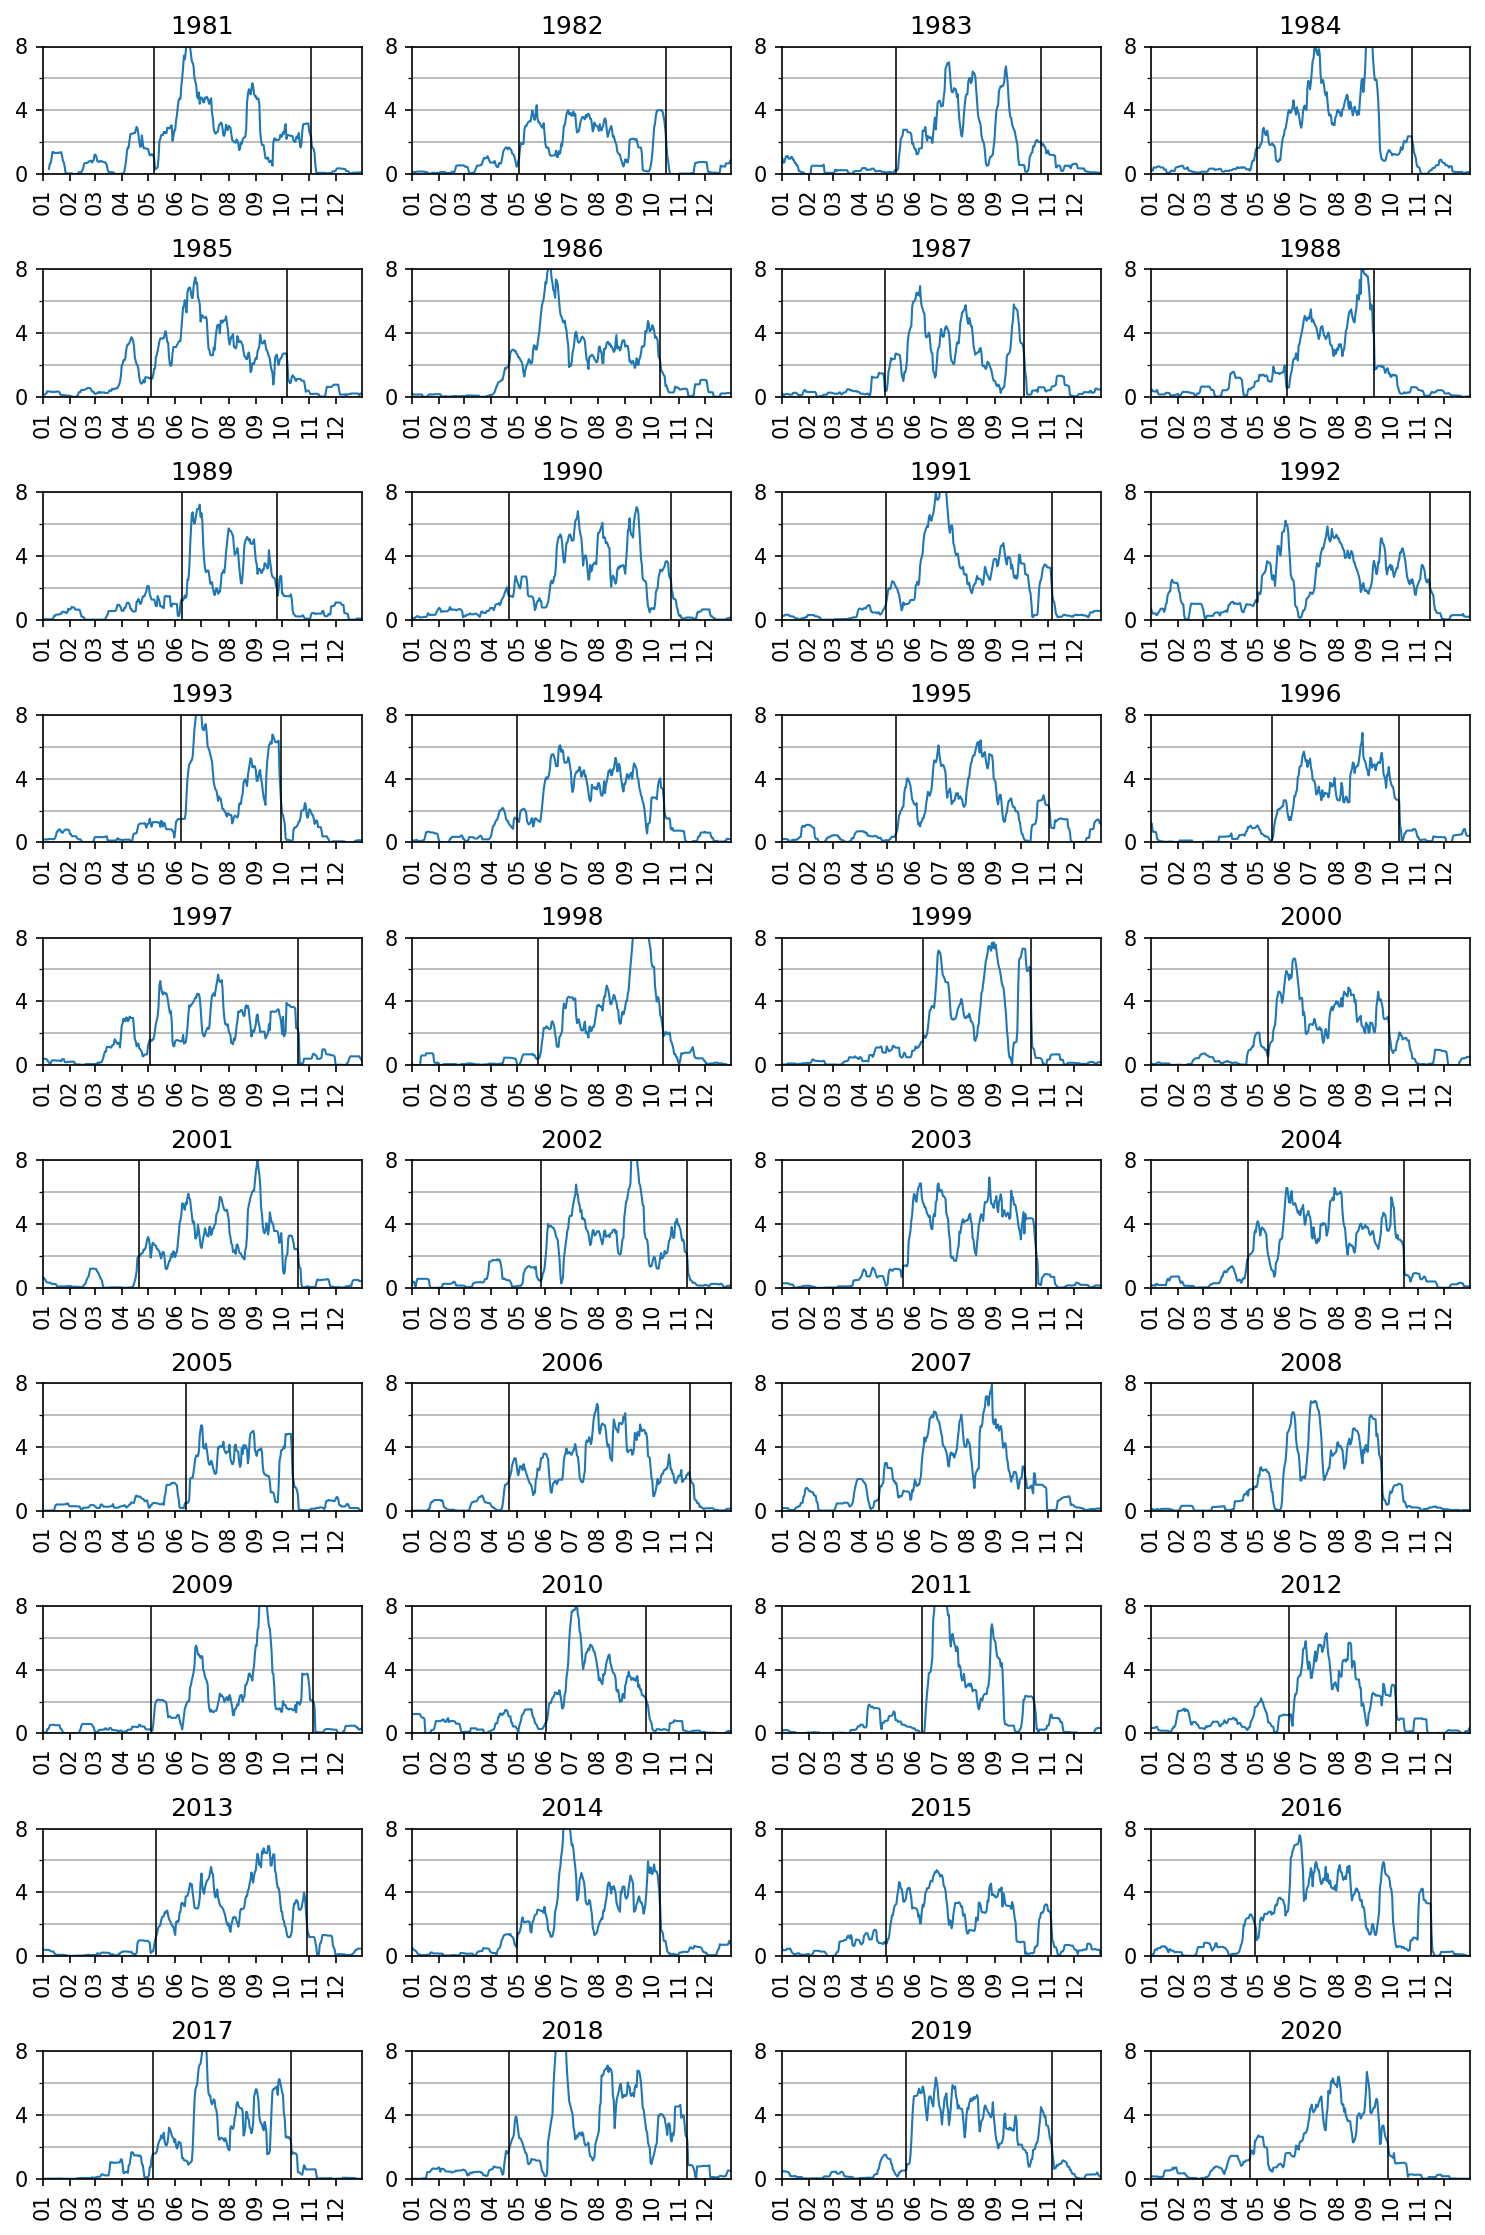

In [57]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = 2
n = 5

m_i = 4

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

c = "Cuenca"

# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n):
    proc.append(c + "_" + str(i)) 

# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral,
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral, 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral, 1)

# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] == n, 0)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] < n, 1)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where( df_mean_ind.index.month.isin(
    range(5, 12) ), 0 )
df_mean_ind.drop(proc[1:],
    axis = 1, inplace = True)

# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
col.append(name + " - Length")

date = pd.DataFrame()
years = range(1981, 2021)

for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & df_mean_ind.index.month.isin(range(m_i, 12)) ]

    row = []

    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax()
        - df_year.iloc[:, 1].idxmax() )

    # Agregamos la fila al DataFrame.
    date = date.append([row])

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"
# Recorremos al inicio de la racha de días de precipitación.
date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(10, 'D')

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)

# Guarda las series de tiempo.
#date.to_csv(path_d + "onset_CHIRPS.csv")
#shift.to_csv(path_d + "shift_CHIRPS.csv")

year = np.arange( 1981, 2021 )

#print(f"Onset     : {onset.day:02d}"
#    + f" {onset.month_name()}")
#print(f"Withdrawal: {withdrawal.day:02d}"
#    + f" {withdrawal.month_name()}")

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]


for i in range( len(year) ):
    df_year = df_mean_ind[ df_mean_ind.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (0, 12), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(0, 8)
    #axes[i].set_ylim(0, np.ceil(df_year.iloc[:, 0].max()) )
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()